In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import glob
import cv2
import matplotlib.pyplot as plt
import random
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
train_path_norm = "/content/drive/My Drive/Dataset/ChestXRay2017/chest_xray/train/NORMAL/"
train_path_pne = "/content/drive/My Drive/Dataset/ChestXRay2017/chest_xray/train/PNEUMONIA/"

test_path_norm = "/content/drive/My Drive/Dataset/ChestXRay2017/chest_xray/test/NORMAL/"
test_path_pne = "/content/drive/My Drive/Dataset/ChestXRay2017/chest_xray/test/PNEUMONIA/"

In [8]:
train_norm_cases = glob.glob(train_path_norm + "*jpeg")
train_pne_cases = glob.glob(train_path_pne + "*jpeg")

test_norm_cases = glob.glob(test_path_norm + "*jpeg")
test_pne_cases = glob.glob(test_path_pne + "*jpeg")

In [9]:
train_list=[]
test_list=[]

for i in train_norm_cases:
    train_list.append([i,0])
    
for i in train_pne_cases:
    train_list.append([i,1])
    
for i in test_norm_cases:
    test_list.append([i,0])
    
for i in test_pne_cases:
    test_list.append([i,1])

In [10]:
random.shuffle(train_list)
random.shuffle(test_list)

In [11]:
val_list = train_list[0:1000]
train_list = train_list[1000:]

In [12]:
train_df = pd.DataFrame(train_list,columns=['image','label'])
test_df = pd.DataFrame(test_list,columns=['image','label'])
val_df = pd.DataFrame(val_list, columns=['image','label'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test')

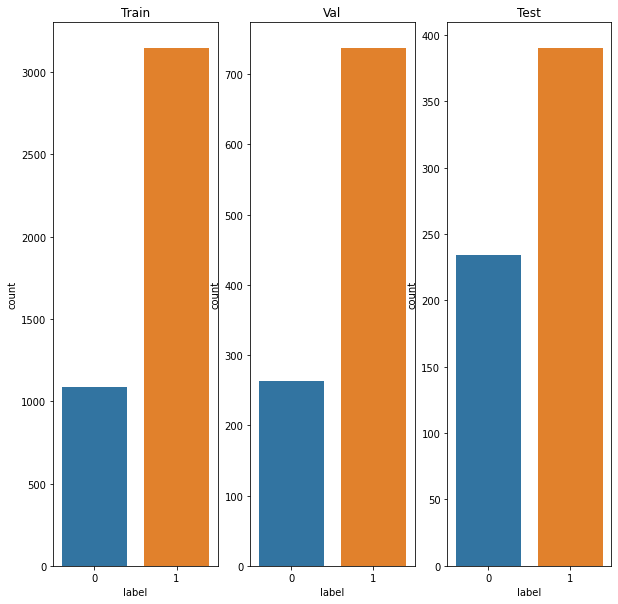

In [13]:
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
sns.countplot(train_df['label'])
plt.title('Train')

plt.subplot(1,3,2)
sns.countplot(val_df['label'])
plt.title('Val')

plt.subplot(1,3,3)
sns.countplot(test_df['label'])
plt.title('Test')

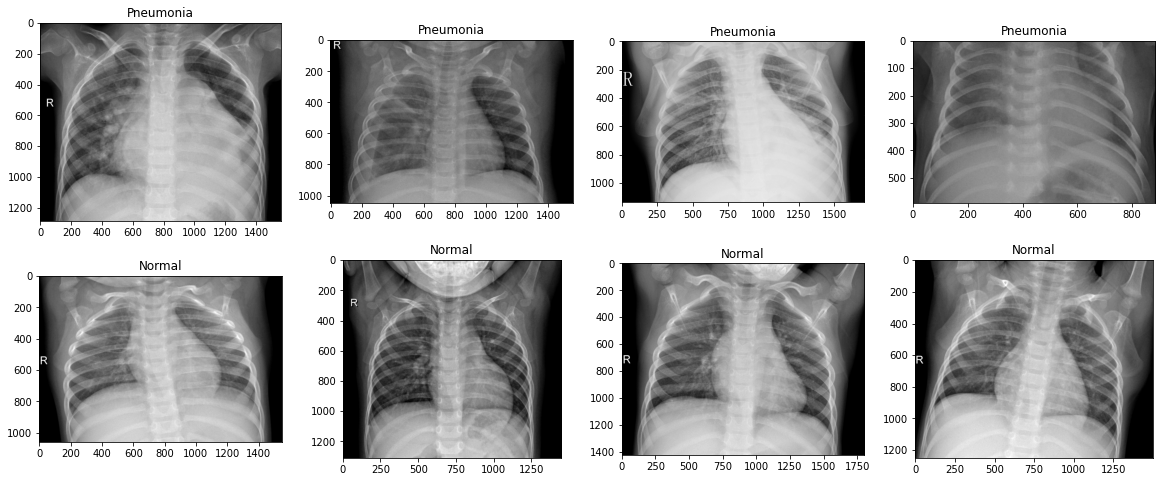

In [14]:
plt.figure(figsize=(20,8))
for i,im_path in enumerate(train_df[train_df['label']==1][0:4]['image']):
    plt.subplot(2,4,i+1)
    a = plt.imread(im_path)
    plt.imshow(a, cmap='gray')
    plt.title("Pneumonia")
    
for i,im_path in enumerate(train_df[train_df['label']==0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    a = plt.imread(im_path)
    plt.imshow(a, cmap='gray')
    plt.title("Normal")

In [15]:
def processor(img_path):
    print(img_path)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (200,200))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (200,200,1))
    return img

def dataset_gen(df):
    img=[]
    label=[]
    for imgs, labels in df.values:
        img.append(processor(imgs))
        label.append(labels)
    
    return np.array(img),np.array(label)

In [16]:
X_train, y_train = dataset_gen(train_df)
X_test, y_test = dataset_gen(test_df)
X_valid, y_valid = dataset_gen(val_df)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/Dataset/ChestXRay2017/chest_xray/train/PNEUMONIA/person1318_virus_2274.jpeg
/content/drive/My Drive/Dataset/ChestXRay2017/chest_xray/train/PNEUMONIA/person543_bacteria_2282.jpeg
/content/drive/My Drive/Dataset/ChestXRay2017/chest_xray/train/PNEUMONIA/person23_bacteria_87.jpeg
/content/drive/My Drive/Dataset/ChestXRay2017/chest_xray/train/PNEUMONIA/person1196_bacteria_3146.jpeg
/content/drive/My Drive/Dataset/ChestXRay2017/chest_xray/train/PNEUMONIA/person464_bacteria_1974.jpeg
/content/drive/My Drive/Dataset/ChestXRay2017/chest_xray/train/PNEUMONIA/person1628_bacteria_4296.jpeg
/content/drive/My Drive/Dataset/ChestXRay2017/chest_xray/train/NORMAL/IM-0414-0001.jpeg
/content/drive/My Drive/Dataset/ChestXRay2017/chest_xray/train/PNEUMONIA/person473_bacteria_2018.jpeg
/content/drive/My Drive/Dataset/ChestXRay2017/chest_xray/train/PNEUMONIA/person370_bacteria_1688.jpeg
/content/drive/My Drive/Dataset/ChestXRay2017/ch

In [17]:
print('X_train_shape: ')
print(X_train.shape)
print('X_test_shape: ')
print(X_test.shape)
print('X_val_shape: ')
print(X_valid.shape)

X_train_shape: 
(4232, 200, 200, 1)
X_test_shape: 
(624, 200, 200, 1)
X_val_shape: 
(1000, 200, 200, 1)


In [18]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_valid = to_categorical(y_valid)

In [19]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=8, kernel_size=(7,7), padding='same',activation='relu',input_shape=((200,200,1))),
    #keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'),
    #keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=16, kernel_size=(5,5), padding='same',activation='relu', input_shape=((200,200,1))),
   # keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'),
    #keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',activation='relu', input_shape=((200,200,1))),
    #keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
   # keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(2, activation='softmax')
])

In [20]:
model.compile(loss='categorical_crossentropy', optimizer = 'nadam', metrics=['accuracy'])
callback = EarlyStopping(monitor='loss', patience=6)

In [21]:
history = model.fit(X_train,y_train, validation_data=(X_valid, y_valid), epochs = 100, callbacks=[callback])

Epoch 1/100
133/133 [==============================] - 47s 112ms/step - loss: 0.4699 - accuracy: 0.7932 - val_loss: 0.2596 - val_accuracy: 0.8930
Epoch 2/100
133/133 [==============================] - 14s 105ms/step - loss: 0.1750 - accuracy: 0.9319 - val_loss: 0.1282 - val_accuracy: 0.9490
Epoch 3/100
133/133 [==============================] - 14s 106ms/step - loss: 0.1025 - accuracy: 0.9622 - val_loss: 0.1429 - val_accuracy: 0.9500
Epoch 4/100
133/133 [==============================] - 14s 106ms/step - loss: 0.0747 - accuracy: 0.9719 - val_loss: 0.2017 - val_accuracy: 0.9310
Epoch 5/100
133/133 [==============================] - 14s 106ms/step - loss: 0.0713 - accuracy: 0.9761 - val_loss: 0.1248 - val_accuracy: 0.9570
Epoch 6/100
133/133 [==============================] - 14s 106ms/step - loss: 0.0497 - accuracy: 0.9823 - val_loss: 0.1131 - val_accuracy: 0.9560
Epoch 7/100
133/133 [==============================] - 14s 106ms/step - loss: 0.0399 - accuracy: 0.9849 - val_loss: 0.0998 -

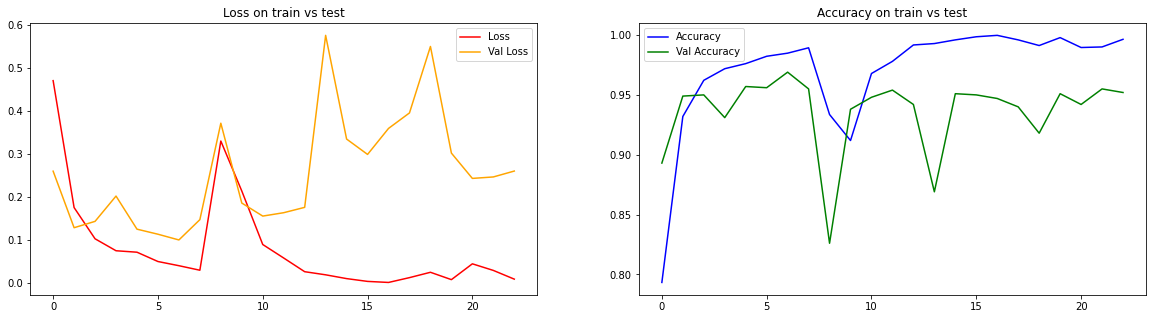

In [22]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')


# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

In [23]:
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)

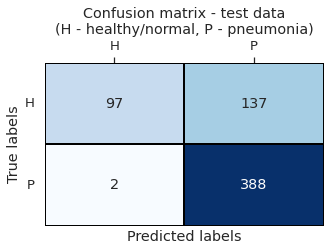

Classification report on test data
              precision    recall  f1-score   support

           0       0.98      0.41      0.58       234
           1       0.74      0.99      0.85       390

    accuracy                           0.78       624
   macro avg       0.86      0.70      0.72       624
weighted avg       0.83      0.78      0.75       624



In [24]:
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['H', 'P'], yticklabels=['H', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data\n(H - healthy/normal, P - pneumonia)')
plt.show()

# print classification report
print('Classification report on test data')
print(clas_r)